In [1]:
import numpy as np
import torch
from torch import nn
import random
import matplotlib.pyplot as plt
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

train_x = ( mnist_trainset.data / 255.0 )
train_y = mnist_trainset.targets

test_x = ( mnist_testset.data / 255.0 )
test_y = mnist_testset.targets

print("Training Data Inputs:", train_x.shape )
print("Training Data Outputs:", train_y.shape )

100%|██████████| 9912422/9912422 [00:00<00:00, 68031324.55it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 75426957.55it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25810861.92it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14976830.79it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Training Data Inputs: torch.Size([60000, 28, 28])
Training Data Outputs: torch.Size([60000])


In [2]:
class DetectorNetwork(nn.Module):
  def __init__(self):
    super(DetectorNetwork, self).__init__()

    self.conv_layer = torch.nn.Conv2d( in_channels = 1, out_channels = 10, kernel_size = 3, stride = 1, bias = True)
    self.layer_1 = torch.nn.Linear( in_features = 26*26*10, out_features = 1, bias=True )

    ## Standard classification type network
    ## Process the input image with a conv layer
    ## Flatten it
    ## Linear layer mapping down to one value, which we
    ## Apply sigmoid to and use as a probability

  def forward(self, input_tensor):
    output = torch.reshape( input_tensor, shape = (-1, 1, 28, 28) ) # Reshaping is necessary here to match the expected input to the conv layer, 1 channel x 28 x 28 pixels
    output = self.conv_layer( output )
    output = nn.ELU()( output )

    output = nn.Flatten()( output )

    output = self.layer_1( output )
    output = nn.Sigmoid()( output )
    return output

class GeneratorNetwork(nn.Module):
  def __init__(self):
    super(GeneratorNetwork, self).__init__()

    self.layer_1 = torch.nn.Linear( in_features = 25, out_features = 10 * 784, bias=True )
    # The input to the generator network will be a random vector of size 25
    # We first map it up to something larger than the end goal (you should've seen in HW 2 that it was useful to map into a larger space before going to a smaller space)

    self.layer_norm = torch.nn.LayerNorm( 10 * 784 )

    self.layer_2 = torch.nn.Linear( in_features = 10 * 784, out_features = 5 * 784, bias = True )
    # Map down to 5*(desired output size)

    self.layer_norm_2 = torch.nn.LayerNorm( 5 * 784 )

    self.layer_3 = torch.nn.Linear( in_features = 5 * 784, out_features = 784, bias = True )
    # Map down to (desired output size)


  def forward(self, input_tensor):
    output = self.layer_1( input_tensor )
    output = nn.ELU()( output )
    output = self.layer_norm( output )
    output = self.layer_2( output )
    output = nn.ELU()( output )
    output = self.layer_norm_2( output )
    output = self.layer_3( output )
    output = nn.Sigmoid()( output ) # We apply a sigmoid to every entry in the vector to make them all between 0 and 1 (and interpretable as pixel values)
    output = torch.reshape( output, shape = (-1, 28, 28) ) # We reshape to the expected image size, 28x28
    return output

In [3]:
generator = GeneratorNetwork()
detector = DetectorNetwork()

In [4]:
random_seeds = torch.randn(100, 25)

In [5]:
images = generator( random_seeds ).detach().numpy() # Generate some example images

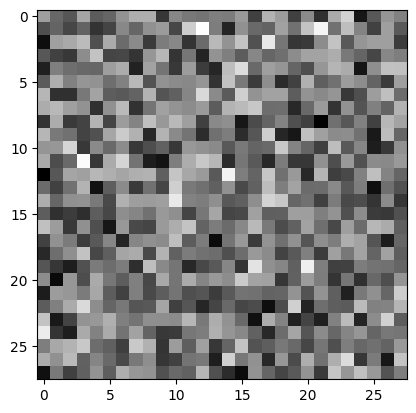

In [6]:
example_image = images[0]

fig = plt.figure
plt.imshow(example_image, cmap='gray')
plt.show()

We see in the above that the initial output of the generator, applied to random seeds, is largely noise in varying shades of gray. This is no surprise - the generator currently has random initial weights, and is doing a random transformation on random input noise, so here we are.

In [10]:
def get_batch( real_images, generator_model, batch_size, label_fakes = True ):

  # This function is going to generate a tensor x_batch of 2*batch_size many images
  # Half of these images will be drawn from 'real_images' at random
  # Half these images will be made using the generator model and technically be fake

  # y_batch will hold class labels corresponding to these images, either 1 for 'real' or 0 for 'fake' (if label_fakes is True)
  # If label_fakes is false, all y_batch labels will be 1, as though all the real images and fake images are in fact 'real'

  x_batch = torch.zeros( size = (2 * batch_size, 28, 28) )
  y_batch = torch.ones( size = (2 * batch_size, 1 ) )

  batch_indices = random.sample( [ i for i in range( real_images.shape[0] ) ], k = batch_size )

  x_batch[0:batch_size] = real_images[ batch_indices ]

  random_seeds = torch.randn( batch_size, 25 )
  images = generator_model( random_seeds )
  x_batch[batch_size:(2*batch_size)] = images

  if label_fakes:
    y_batch[batch_size:(2*batch_size)] = 0

  return x_batch, y_batch

In [11]:
def classification_loss( actual_labels, predictions ):
  return torch.mean( -1 * torch.log( predictions + 0.0001 ) * actual_labels - torch.log( 1 - predictions + 0.0001 ) * (1 - actual_labels ) )

  # Computes the mean log loss (binary cross entropy) between a vector of actual labels and a vector of predicted probabiltiies
  # The 0.0001 is a fudge factor to keep me from taking the log of something too close to 0.

def accuracy( actual_labels, predictions ):
  return ( torch.sum( torch.abs( predictions - actual_labels ) < 0.5 ) / ( actual_labels.shape[0] ) ).item()

  # Note that if the actual label is 0, and the prediction is anything < 0.5, then we can view that as the model being 'correct'
  # If the actual label is 1 and the prediction is anything > 0.5, we can few that as the model being 'correct'

  # Taken together, as long as | label - prediction | < 0.5, we can view the prediction as 'correct'.
  # This simply calculates how often this occurs over the set of predictions and labels

def train_discriminator( generator_model, discriminator_model, optimizer_d, batch_size, real_images):
  # In this function we are treating the generator as fixed, and training the discriminator to better distinguish between
  # Real images and fake images
  # We will pass it a batch of images (some labeled real, some labeled fake), compute the loss based on its predictions,
  # and tweak the discriminator to try to reduce that loss

  discriminator_model.train()
  generator_model.eval()

  optimizer_d.zero_grad()

  x_batch, y_batch = get_batch( real_images, generator_model, batch_size, label_fakes = True ) # Note we want to correctly label real as real and fake as fake

  predictions = discriminator_model( x_batch )
  loss = classification_loss( y_batch, predictions )

  loss.backward()
  optimizer_d.step()

  current_accuracy = accuracy( y_batch, predictions )

  return loss.item(), current_accuracy # Returns the current loss and the accuracy


def train_generator( generator_model, discriminator_model, optimizer_g, batch_size, real_images):
  # In this function, we want to treat the discriminator as fixed, and train the generator
  # So we are going to define the loss of the generator /in terms of the discriminator/
  # If the discriminator is outputting probabilities that are close to zero, the loss of the generator is high
  # since the discriminator can tell that the images are fake.
  # If the discriminator is outputing probabilities that are close to 1, the loss of the generator is low
  # since the discriminator is classifying the fake images as real

  generator_model.train()
  discriminator_model.eval()

  optimizer_g.zero_grad()

  x_batch, y_batch = get_batch( real_images, generator_model, batch_size, label_fakes = False )
  # Note that when we get the batch of images here, all are labeled as 'real'
  # So that the classification loss is going to measure how close the discriminator predictions are to labeling the fake images as real

  predictions = discriminator_model( x_batch )
  loss = classification_loss( y_batch, predictions )

  loss.backward()
  optimizer_g.step()

  current_accuracy = accuracy( y_batch, predictions )

  return loss.item(), current_accuracy

In [7]:
generator = GeneratorNetwork()
detector = DetectorNetwork()

generator_optimizer = optim.Adam( generator.parameters(), lr = 0.002, weight_decay = 0.0001 ) # Build an optimizer for each network
discriminator_optimizer = optim.Adam( detector.parameters(), lr = 0.002, weight_decay = 0.0001 ) # Learning rates settled on by experiment, some amount of weight decay (ridge regularization) seemed to imrpove my results

In [15]:
batch_size = 128 #update based on 128 real & fake images at a time (256 images in total)

print("Training Detector")
disc_loss, current_accuracy = train_discriminator( generator, detector, discriminator_optimizer, batch_size, train_x )
print( disc_loss, current_accuracy )
while current_accuracy < 1: # Loop until the discriminator correctly ids 100% of the images in the batch. This is a very strong termination condition, maybe too strong.
  disc_loss, current_accuracy = train_discriminator( generator, detector, discriminator_optimizer, batch_size, train_x )
  print( disc_loss, current_accuracy )
print()

Training Detector
2.351909637451172 0.5
1.8432340621948242 0.5
1.1120425462722778 0.48828125
0.6899314522743225 0.703125
0.7410529851913452 0.54296875
0.7866930365562439 0.5
0.7001900672912598 0.5078125
0.5067621469497681 0.58984375
0.2716664969921112 0.91015625
0.12173731625080109 1.0



In [16]:
print("Training Generator")
gen_loss, current_accuracy = train_generator( generator, detector, generator_optimizer, batch_size, train_x)
print( gen_loss, current_accuracy )
while current_accuracy < 1: # Train the generator, looping until the generated images are IDed as real 100% of the time (for one batch)
  gen_loss, current_accuracy = train_generator( generator, detector, generator_optimizer, batch_size, train_x)
  print( gen_loss, current_accuracy )
print()

Training Generator
1.5493353605270386 0.5
1.4849796295166016 0.5
1.3114731311798096 0.5
1.117074728012085 0.5
0.918559193611145 0.5
0.7711384296417236 0.52734375
0.6821337342262268 0.57421875
0.5497151017189026 0.609375
0.43621140718460083 0.7109375
0.37169551849365234 0.7890625
0.327924907207489 0.88671875
0.2572984993457794 0.9765625
0.21688123047351837 1.0



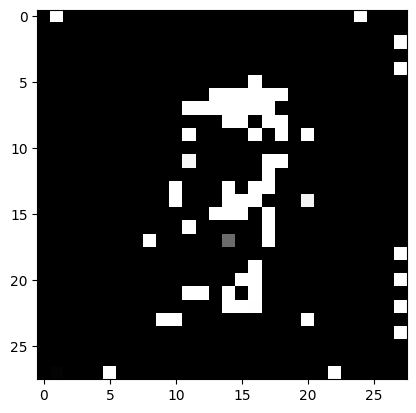

In [17]:
random_seeds = torch.randn(1, 25)
images = generator( random_seeds ).detach().numpy() # Generate an example image based on the current generator
example_image = images[0]

fig = plt.figure
plt.imshow(example_image, cmap='gray')
plt.show()

Training then continues, training the discriminator with the newly trained generator, then training the generator with the newly trained discriminator, back and forth until we get to some kind of convergence. We can loop this, as below.

Training Detector
Training Generator



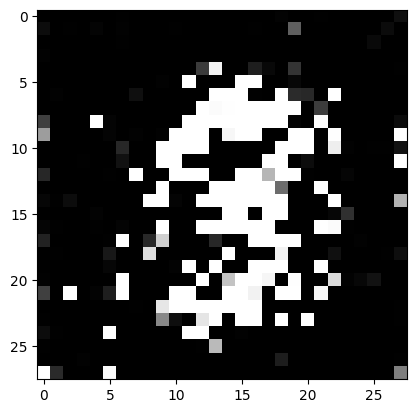

Training Detector
Training Generator



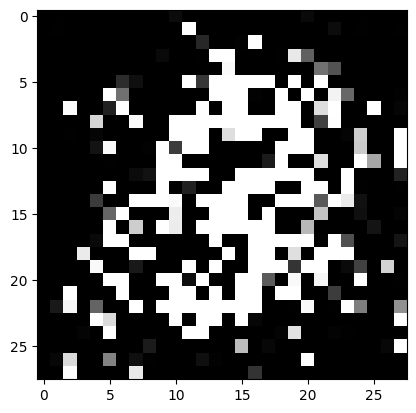

Training Detector
Training Generator



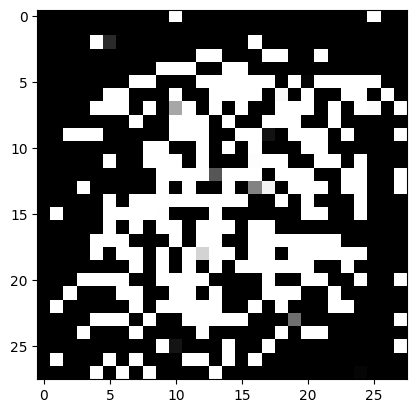

Training Detector
Training Generator



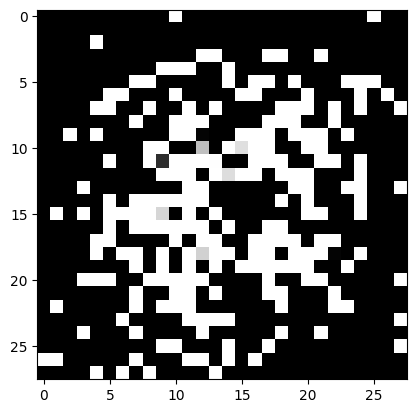

Training Detector
Training Generator



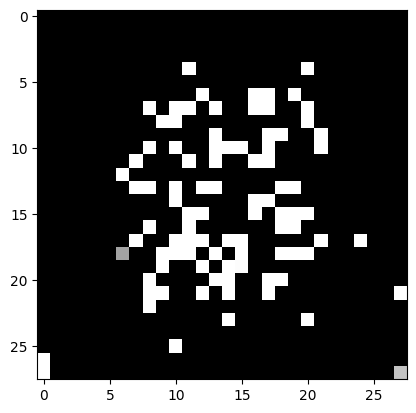

Training Detector
Training Generator



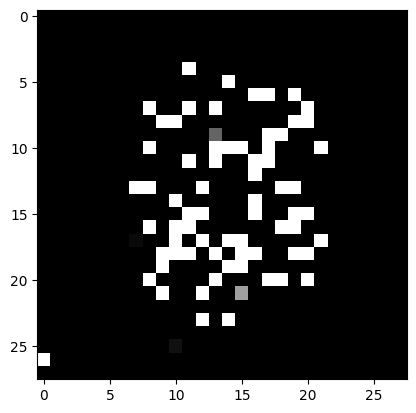

Training Detector
Training Generator


KeyboardInterrupt: 

In [31]:
for i in range(100):
  print("Training Detector")
  disc_loss, current_accuracy = train_discriminator( generator, detector, discriminator_optimizer, batch_size, train_x )
  while current_accuracy < 0.9:
    disc_loss, current_accuracy = train_discriminator( generator, detector, discriminator_optimizer, batch_size, train_x )
  print("Training Generator")
  gen_loss, current_accuracy = train_generator( generator, detector, generator_optimizer, batch_size, train_x)
  while current_accuracy < 0.9:
    gen_loss, current_accuracy = train_generator( generator, detector, generator_optimizer, batch_size, train_x)
  print()

  random_seeds = torch.randn(1, 25)
  images = generator( random_seeds ).detach().numpy()
  example_image = images[0]

  fig = plt.figure
  plt.imshow(example_image, cmap='gray')
  plt.show()